# Presets

In [1]:
using PyPlot

In [2]:
using Random

In [3]:
using ReinforcementLearning 

In [4]:
arrows = Dict(1 => '⇐', 2 => '⇓', 3 => '⇒', 4 => '⇑');

grid4x4= ['S' 'F' 'F' 'F';
        'F' 'H' 'F' 'H';
        'F' 'F' 'F' 'H';
        'H' 'F' 'F' 'G'];

grid8x8 =['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'F';
        'F' 'F' 'F' 'F' 'F' 'H' 'F' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'F';
        'F' 'H' 'H' 'F' 'F' 'F' 'H' 'F';
        'F' 'H' 'F' 'F' 'H' 'F' 'H' 'F';
        'F' 'F' 'F' 'H' 'F' 'F' 'F' 'G';];

# Auxilary functions

In [5]:
function get_grid(dim, p_holes, seed = 234)
    Random.seed!(seed)
    grid = [rand() < p_holes ? 'H' : 'F' for i in 1:dim, j in 1:dim]
    grid[1,1] = 'S'
    grid[end,end] = 'G'
    return grid
end;

function random_policy(grid,actions = actions)
    P = rand(Int,size(grid))
    for i = 1:length(grid)
        P[i] = rand(1:length(actions))
    end
    return P
end;

function print_policy(P, grid, arrows = arrows)
    Policy = rand(Char,size(grid))
    for i = 1:length(grid)
        if grid[i] == 'F' || grid[i] == 'S' 
            Policy[i] = arrows[P[i]]
        elseif grid[i] == 'H' 
            Policy[i] = '⦷'
        else
            Policy[i] = grid[i]
        end
    end
    return Policy
end;

# Defining Frozen Lake environment

In [6]:
mutable struct FrozenLakeEnv <: AbstractEnv
    reward::Union{Nothing, Float64}
    rewards::Dict{Char, Float64} 
    actions::Dict{Int64, Tuple{Int64, Int64}}  
    world::Matrix{Char} 
    ES::Bool 
    position::Int 
end;
Main.FrozenLakeEnv

FrozenLakeEnv

In [7]:
function FrozenLakeEnv(grid::Union{Int,Symbol} = :grid4x4; ES::Bool = false) 
    if typeof(grid) == Int
        world = get_grid(grid, 0.1)
    elseif grid == :grid4x4
        world = grid4x4
    elseif grid == :grid8x8
        world = grid8x8
    else
        @error "unknown grid"
    end
    ES == true ? position = rand(1:length(world)) : position = 1
    return FrozenLakeEnv(nothing, Dict('S' => -0.05, 'G' => 1.0, 'H' => -1.0, 'F' => -0.05),
    Dict(1 => (0,-1), 2 => (1,0), 3 => (0,1), 4 => (-1,0)), 
        world, ES, position)
end;

In [8]:
RLBase.action_space(env::FrozenLakeEnv) = Base.OneTo(length(env.actions))
RLBase.state_space(env::FrozenLakeEnv) = Base.OneTo(length(env.world))
RLBase.reward(env::FrozenLakeEnv) = env.reward
RLBase.state(env::FrozenLakeEnv) = env.position
RLBase.is_terminated(env::FrozenLakeEnv) = env.reward == 1.0 || env.reward == -1.0 
function RLBase.reset!(env::FrozenLakeEnv) 
    env.reward = nothing
    env.ES == true ? env.position = rand(state_space(env)) : env.position = 1
end

In [9]:
function (x::FrozenLakeEnv)(action)
    @assert action in action_space(x)
    direction = x.actions[action]
    cartesian_state = (CartesianIndices(x.world)[x.position][1],
                        CartesianIndices(x.world)[x.position][2])
    sides = filter(y -> !(y in [direction, direction .* -1]), collect(values(x.actions)))
    p = rand()
    if p <= 0.8
        new_state = cartesian_state .+ direction
    elseif p <= 0.9
        new_state = cartesian_state .+ sides[1]
    else
        new_state = cartesian_state .+ sides[2]
    end
    if new_state[1] in (1:size(x.world,1)) && new_state[2] in (1:size(x.world,2))
        x.position = LinearIndices(x.world)[new_state[1],new_state[2]]
        x.reward = x.rewards[x.world[x.position]]
    else
        x.position = LinearIndices(x.world)[cartesian_state[1],cartesian_state[2]]
        x.reward = x.rewards[x.world[x.position]]
    end
end;

In [10]:
env = FrozenLakeEnv(:grid8x8, ES = false);
RLBase.test_runnable!(env);

Test Summary:                    | Pass  Total  Time
random policy with FrozenLakeEnv | 2000   2000  0.1s


# Defining Agent

In [11]:
mutable struct AgentMC
    env::FrozenLakeEnv
    ϵ::Float64
    β::Float64
    Q::Array{Float64,2}
    C::Array{Float64,2}
    π::Array{Int}
end

function AgentMC(env; ϵ = .2, β = 0.999)
    return AgentMC(env,ϵ, β,
        zeros(length(env.world), length(action_space(env))),
        zeros(length(env.world), length(action_space(env))),
        rand(1:length(action_space(env)),length(env.world)))
end

AgentMC

# On-policy functions

In [12]:
function get_episode(agent, π = agent.π; maxstep = 1000)
    step = 1
    if agent.env.ES == true 
        S = rand(state_space(agent.env)) 
        action = rand(action_space(agent.env))
    else
        S = 1
        rand() < agent.ϵ ? action = rand(action_space(agent.env)) : action = π[S]
    end
    agent.env(action)
    r = agent.env.reward
    episode = [(S, action, r)]
    if is_terminated(agent.env)
        reset!(agent.env)
        return episode
    end
    while step < maxstep
        S = state(agent.env)
        (rand() < agent.ϵ) && (agent.env.ES == false) ? action = rand(action_space(agent.env)) : action = π[S]
        agent.env(action)
        r = agent.env.reward
        push!(episode, (S, action,r))
        if is_terminated(agent.env)
            reset!(agent.env)
            break
        end
        step +=1
    end
    return episode
end;

In [13]:
function update!(agent)
    episode = get_episode(agent)
    R = 0
    occur_first = reverse(vcat(findfirst.(isequal.(unique(episode)), [episode]), length(episode) + 1))
    for k = 2:length(occur_first) 
        for i = occur_first[k-1] - 1:-1:occur_first[k]
            state,action,r = episode[i]
            R = agent.β*R + r
        end
        state,action,r = episode[occur_first[k]]
        agent.C[state,action] += 1
        agent.Q[state,action] += (R - agent.Q[state,action])/ agent.C[state,action] 
        agent.π[state] = argmax(agent.Q[state,:])
    end  
    episode[end][3] == 1.0 ? (return 1.0) : (return 0.0)
end;

In [14]:
function MC!(agent; maxit = 100000)
    iter = 0
    successes = 0.0
    success_rate = []
    while iter < maxit
        successes += update!(agent)
        push!(success_rate, successes/iter)
        iter +=1
    end
    return success_rate
end;

# Off-policy functions

In [15]:
function get_episode_offpolicy(agent, μ; maxstep = 1000)
    step = 1
    W = 1.0
    episode = []
    
    agent.env.ES == true ? S = rand(state_space(agent.env)) : S = 1 # wybieramy startowy stan
    
    action = Int(μ[S, 1])    # wybieramy akcję z strategii docelowej dla stanu S
    agent.env(action)        # robimy tą akcję
    r = agent.env.reward     # liczymy nagrodę z akcji
    push!(episode, (S, action, r, W))   # uzupelniamy epizod
    W *= agent.π[S] == action ? (1.0 / μ[S, 2]) : 0.0   # aktualizujemy wagę epizodu
    if is_terminated(agent.env)    # sprawdzamy warunek terminacji
        reset!(agent.env)
        return episode
    end
    
    while step < maxstep    # aż gra się nie skończy (porażką w przerębli albo w punkcie końcowym)
        S = state(agent.env)  # robimy to samo co wyżej ...
        action = Int(μ[S, 1])
        agent.env(action)
        r = agent.env.reward
        push!(episode, (S, action, r, W))
        W *= agent.π[S] == action ? (1.0 / μ[S, 2]) : 0.0
        if is_terminated(agent.env)
            reset!(agent.env)
            break
        end
        step +=1
    end
    return episode
end;

In [16]:
function update_offpolicy!(agent, μ)
    episode = get_episode_offpolicy(agent, μ)
    R = 0
    W = 1.0
    occur_first = reverse(vcat(findfirst.(isequal.(unique(episode)), [episode]), length(episode) + 1))
    for k = 2:length(occur_first)
        for i = occur_first[k-1] - 1:-1:occur_first[k]
            state,action,r = episode[i]
            R = agent.β*R + r
        end
        state, action, r, importance_sampling_ratio = episode[occur_first[k]]
        # nadajemy wagę liczniku wydarzeń: jak wydarzenie skończyło się sukcesem to waga jest większa 
        agent.C[state, action] += importance_sampling_ratio * W
        agent.Q[state, action] = agent.Q[state, action] + (W / agent.C[state, action]) * (R - agent.Q[state, action])
        agent.π[state] = argmax(agent.Q[state, :])
        if W == 0.0
            break
        end
        W *= importance_sampling_ratio
    end  
    episode[end][3] == 1.0 ? (return 1.0) : (return 0.0)
end;

In [17]:
function MC_off!(agent, target_policy; maxit = 100000)
    iter = 0
    successes = 0.0
    success_rate = []
    while iter < maxit
        successes += update_offpolicy!(agent, target_policy)
        push!(success_rate, successes/iter)
        iter +=1
    end
    return success_rate
end;

# Checking

In [27]:
agent = AgentMC(FrozenLakeEnv(:grid4x4, ES = false));
success_rate = MC!(agent, maxit = 500_000)
print_policy(agent.π, agent.env.world)

4×4 Matrix{Char}:
 '⇓'  '⇒'  '⇓'  '⇐'
 '⇓'  '⦷'  '⇓'  '⦷'
 '⇒'  '⇓'  '⇓'  '⦷'
 '⦷'  '⇒'  '⇒'  'G'

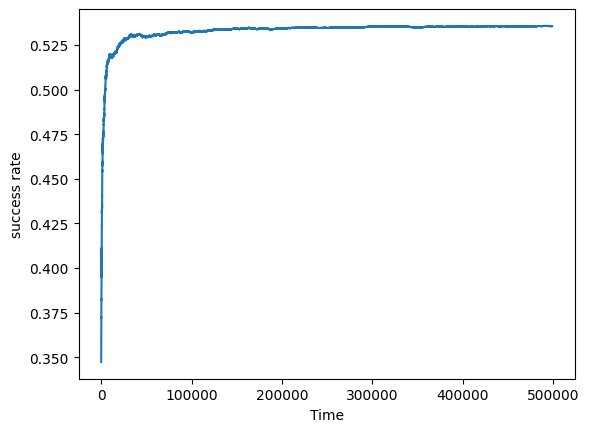

PyObject Text(24.0, 0.5, 'success rate')

In [28]:
plot(success_rate[1000:end])
xlabel("Time")
ylabel("success rate")

In [20]:
target_policy = ones(Float64, 16, 2);
# najlepsza wybrana akcja w stanach 1-16
target_policy[:, 1] .= [3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 1, 1, 1, 3];
# waga tej akcji
target_policy[:, 2] .= [1, .9, .9, .9, .9, .9, .9, .9, .9, .9, .9, .9, .9, .9, .9, .9];
println("Selected target policy:")
print_policy(target_policy[:, 1], agent.env.world)

Selected target policy:


4×4 Matrix{Char}:
 '⇒'  '⇒'  '⇓'  '⇐'
 '⇓'  '⦷'  '⇓'  '⦷'
 '⇒'  '⇓'  '⇓'  '⦷'
 '⦷'  '⇒'  '⇒'  'G'

In [26]:
agent_off = AgentMC(FrozenLakeEnv(:grid4x4, ES = false));
success_rate_off = MC_off!(agent_off, target_policy; maxit = 500_000)
println("Actual learned policy:")
print_policy(agent_off.π, agent_off.env.world)

Actual learned policy:


4×4 Matrix{Char}:
 '⇒'  '⇒'  '⇓'  '⇓'
 '⇓'  '⦷'  '⇓'  '⦷'
 '⇒'  '⇐'  '⇓'  '⦷'
 '⦷'  '⇒'  '⇒'  'G'

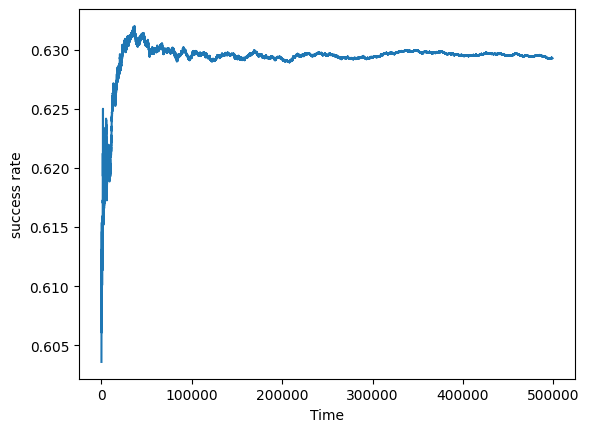

PyObject Text(24.0, 0.5, 'success rate')

In [22]:
plot(success_rate_off[1000:end])
xlabel("Time")
ylabel("success rate")

# Discussion

W rozważanym zadaniu domowym zaimplementowany został algorytm Monte Carlo Off policy. Dalej został on porównany z algorytmem On policy, pokazanym na zajęciach.

Ogólnie, wyniki wskazywały, że w przypadku Off policy dla siatki gry 4x4 prawdopodobieństwo sukcesu było średnio większe o 5 p.p. Akurat w tym wygenerowanym losowo przypadku dostałem wynik o 10 p.p. lepszy. Wydaje się, że najtrudniejszym dla algorytmu On policy była akcja dla stanu S=1 ('⇓'). Częściej doprowadzało to do sytuacji, gdzie agent trafiał w lewy górny róg, w którym większa była możliwość pośliźnięcia się i trafienia do przerębli. Rolę zagrał tutaj dobry wybór pierwszej akcji w strategii docelowej (target policy).

P.S. miałem problem z puszczaniem przykładu z Blackjackiem, wyskakiwał error związany z indeksacją.